In [3]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import xgboost as xg
from sklearn.model_selection import GridSearchCV
import catboost as cb
from IPython.display import display
from IPython.display import HTML
import random
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Exploring Feature Importance for Laptop Prices

In [4]:
#initial

#read in
train_file_path = 'C:\\Users\\maxch\\Downloads\\laptops.csv'
df = pd.read_csv(train_file_path)
print(f"Dataset has {df.shape[1]-2} features and {df.shape[0]} entries".format(df.shape))
print('First few rows of dataset')

display(df.head(5))
print('Data summary')
display(df.info())

print(f'Number of unique values in Laptop = {df["Laptop"].nunique()}')

Dataset has 10 features and 2160 entries
First few rows of dataset


,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


Data summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Laptop        2160 non-null   object 
 1   Status        2160 non-null   object 
 2   Brand         2160 non-null   object 
 3   Model         2160 non-null   object 
 4   CPU           2160 non-null   object 
 5   RAM           2160 non-null   int64  
 6   Storage       2160 non-null   int64  
 7   Storage type  2118 non-null   object 
 8   GPU           789 non-null    object 
 9   Screen        2156 non-null   float64
 10  Touch         2160 non-null   object 
 11  Final Price   2160 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 202.6+ KB


None

Number of unique values in Laptop = 2160


In [5]:
df.corr()

,RAM,Storage,Screen,Final Price
RAM,1.000000,0.751297,0.361404,0.724946
Storage,0.751297,1.000000,0.398025,0.695631
Screen,0.361404,0.398025,1.000000,0.268359
Final Price,0.724946,0.695631,0.268359,1.000000


## Missing Data

Looking over the information regarding the data, Storage Type, GPU and Screen have null data in them. Entries with a null GPU represent computers without a GPU so these null values can be replaced with another categorical 'None value. Looking over rows with null, Screen only has 4 rows.

In [4]:
df[df['Screen'].isna()]

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
624,Acer Extensa 15 EX215-54 Intel Core i5-1135G7/...,New,Acer,Extensa,Intel Core i5,8,256,SSD,NaN,NaN,No,524.99
1430,HP ENVY x360 2-in-1 Laptop 15-ew0008np Intel C...,New,HP,Envy,Intel Core i7,16,512,SSD,RTX 2050,NaN,Yes,1863.52
1503,Lenovo IdeaPad Gaming 3 15ACH6 AMD Ryzen 5 560...,New,Lenovo,IdeaPad,AMD Ryzen 5,16,512,SSD,RTX 3060,NaN,No,1505.00
1548,Lenovo ThinkPad P15 Gen 2 Intel Core i7-11850H...,New,Lenovo,ThinkPad,Intel Core i7,16,512,SSD,RTX A2000,NaN,No,2569.00


Looking these up, these do have normal screen size and was missing at random Due to the low amount of rows affected. I've removed these rows.
Regarding rows with a null Storage Type, this was again entry error missing at random. As this affected a significant amount of data, I have replaced it with  SSD which is the most common value by far

In [5]:
display(df.groupby('Storage type').size())
df['Storage type'].fillna('SSD',inplace=True)
df['GPU'].fillna('None',inplace=True)
df.dropna(inplace=True)

Storage type
SSD     2062
eMMC      56
dtype: int64

Checking for outliers, the only actual numerical column to be checked is final price as while there are other columns containing numbers (RAM and Storage) these only have several different values and are closer to categorical variables.

min price is £201.05
max price is £7150.47


(201.05, 7150.47)

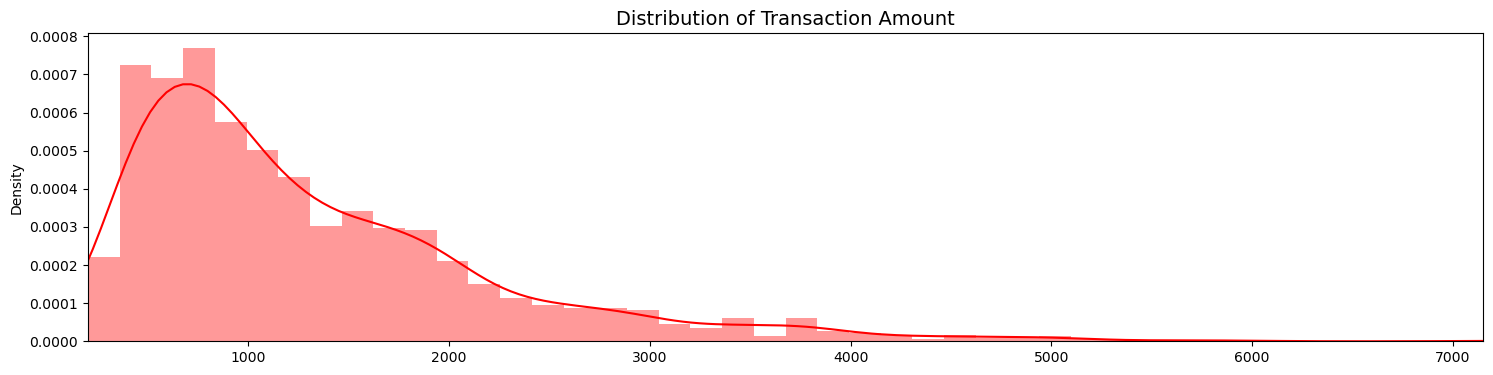

In [6]:
#plotting

print('min price is £{0}'.format(df['Final Price'].min()))
print('max price is £{0}'.format(df['Final Price'].max()))

#hist 
fig, ax = plt.subplots(1, 1, figsize=(18,4))

amount_val = df['Final Price'].values
sns.distplot(amount_val, ax=ax, color='r')
ax.set_title('Distribution of Transaction Amount', fontsize=14)
ax.set_xlim([min(amount_val), max(amount_val)])


Prices generally cluster around £1000 Though the prices range from £200-7000 , none of these are infeasible laptop prices.


## Exploratory analysis

Plotting a boxplot of the categorical variables against price to see which ones affect price:

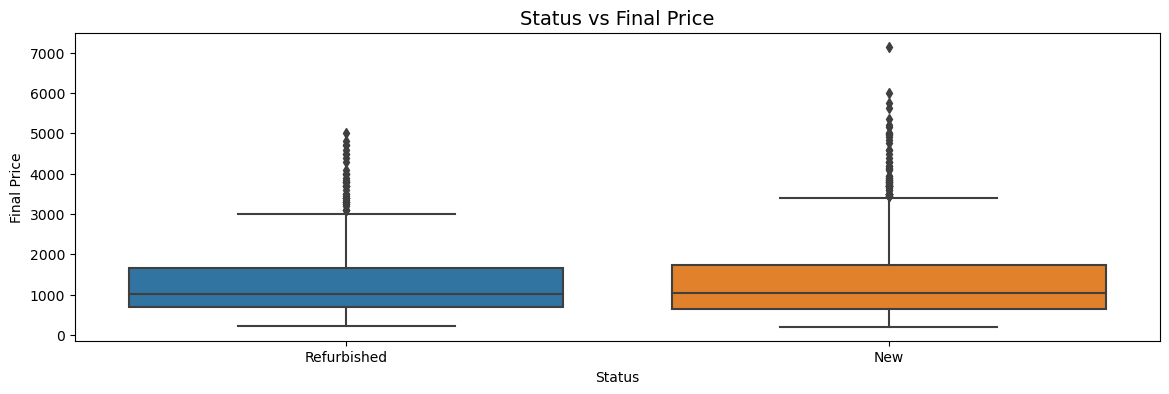

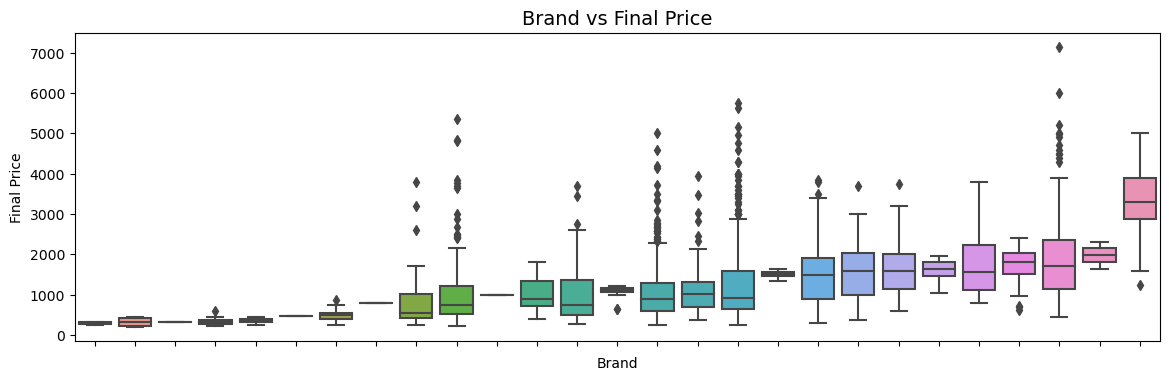

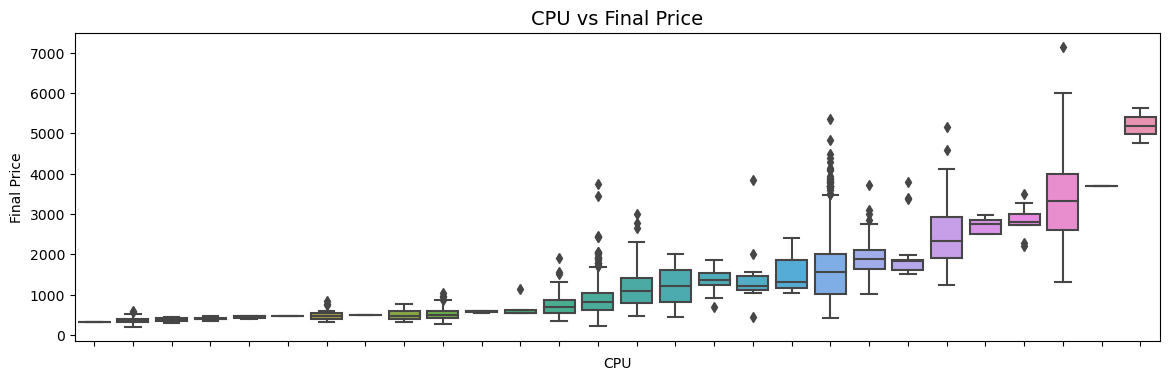

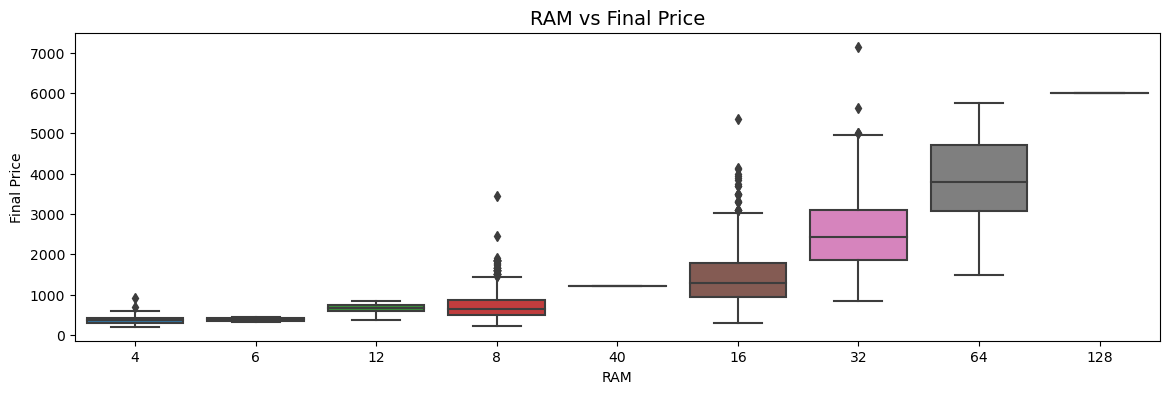

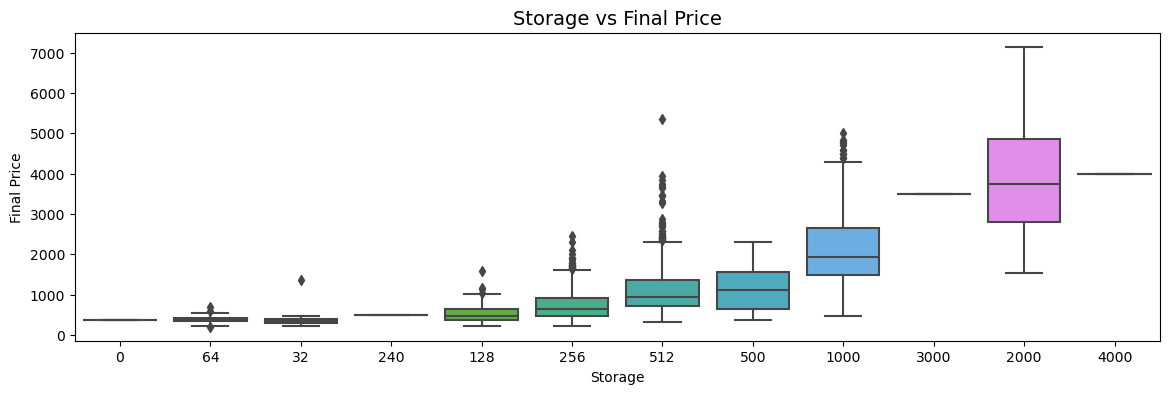

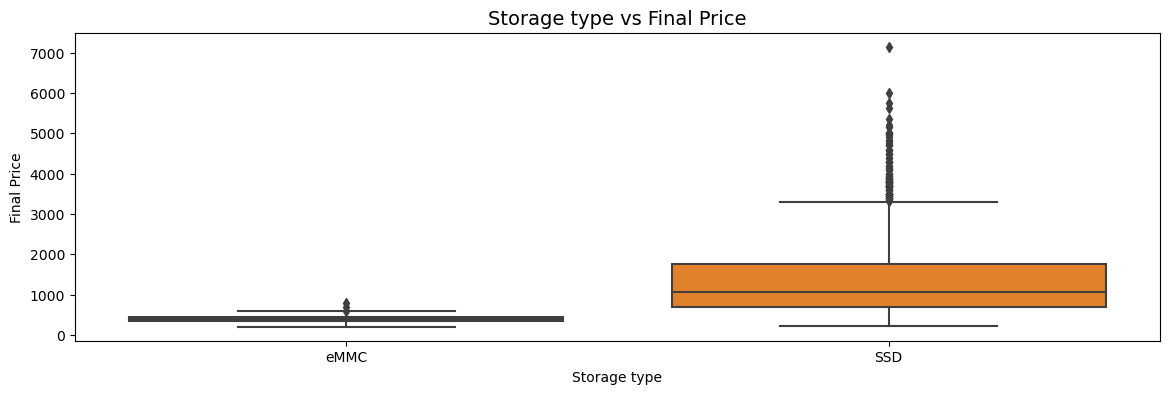

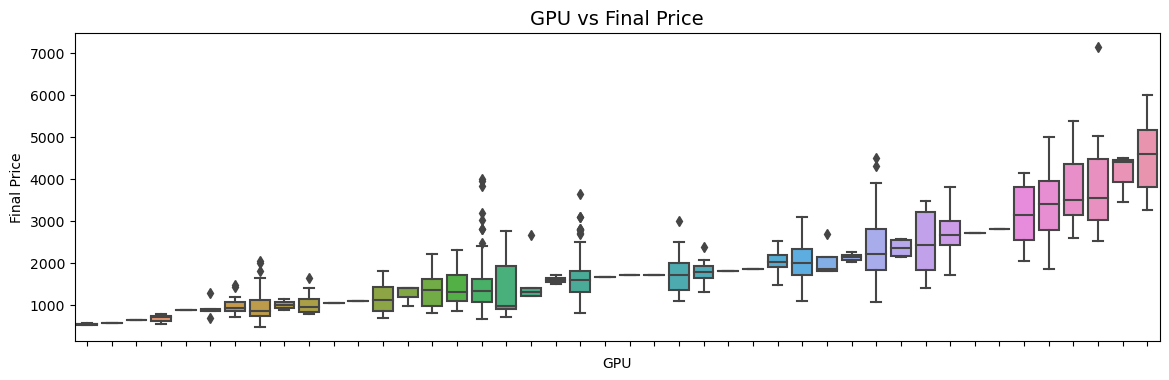

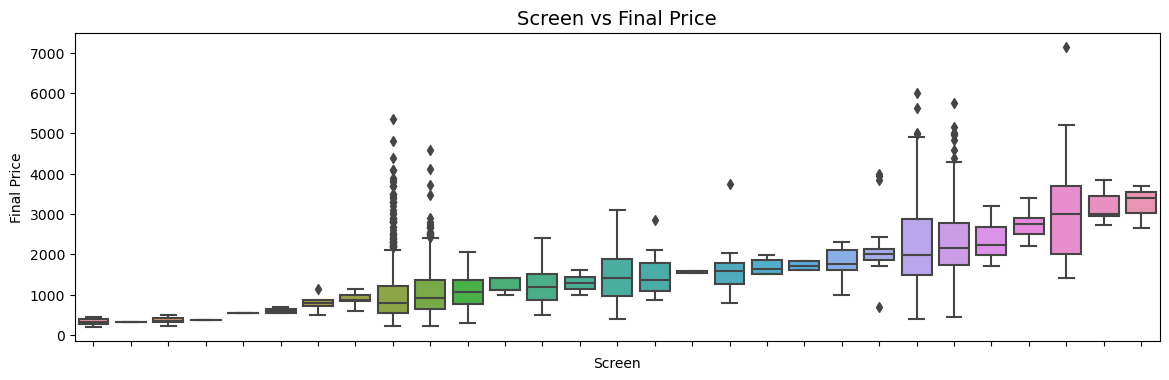

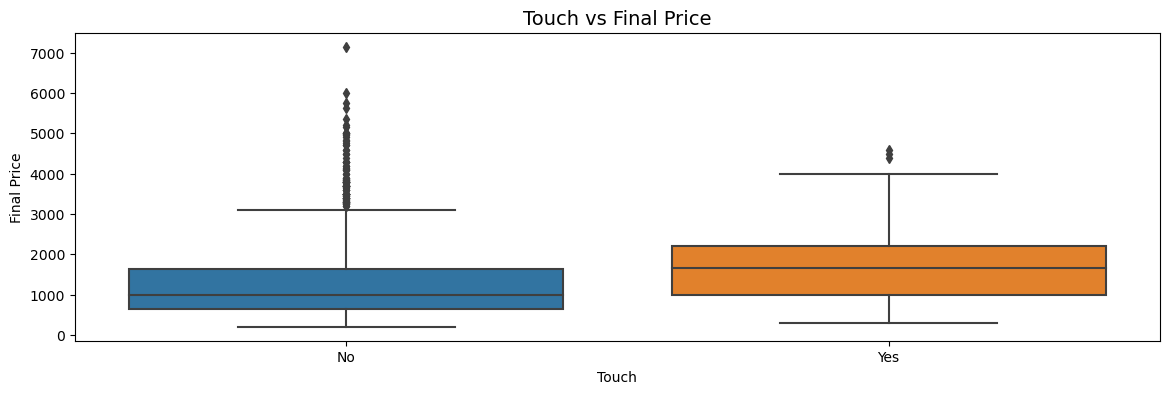

In [38]:
for column in df.drop(['Final Price','Laptop','Model'],axis=1).columns:
    my_order = df.groupby(by=[column])["Final Price"].mean().iloc[::-1].sort_values().index
    
    if len(df[column].unique())<20:
        fig, ax = plt.subplots(1, 1, figsize=(14,4))
        ax.set_title(f'{column} vs Final Price', fontsize=14)
        a=sns.boxplot(x=df[column],y=df['Final Price'], ax=ax,order=my_order)
        plt.show()
    else:
        fig, ax = plt.subplots(1, 1, figsize=(14,4))
     
     
        ax.set_title(f'{column} vs Final Price', fontsize=14)
        a=sns.boxplot(x=df[column],y=df['Final Price'], ax=ax,order=my_order)
       
        a.set(xticklabels=[])  
        plt.show()

 Most features significantly affect the mean Final Price with quite a few features have possible values with low means similar to each other but also values with substantially higher means.

# Anova

Using Anova to more formally check which features affect the final price

In [8]:
significant_columns = []

for col in df.drop(['Laptop','Final Price'],axis=1).columns:
    print(f'ANOVA for column {col}')
    price_list = []
    unique_list=df[col].unique()
    for unique_var in unique_list:
        if len(df[df[col]==unique_var]['Final Price'])>3:
            price_list.append(df[df[col]==unique_var]['Final Price'])
    print(f'p value = {stats.f_oneway(*price_list).pvalue}')
    if float(stats.f_oneway(*price_list).pvalue)<0.05:
        significant_columns.append(col)        

ANOVA for column Status
p value = 0.9955536571240677
ANOVA for column Brand
p value = 7.987711447758045e-106
ANOVA for column Model
p value = 0.0
ANOVA for column CPU
p value = 0.0
ANOVA for column RAM
p value = 0.0
ANOVA for column Storage
p value = 2.65591150957e-312
ANOVA for column Storage type
p value = 4.6424327803249e-14
ANOVA for column GPU
p value = 0.0
ANOVA for column Screen
p value = 2.522241032676373e-193
ANOVA for column Touch
p value = 5.563675319923364e-13


In [9]:
print(f'columns with significant differences in variances are {str(significant_columns)}')

columns with significant differences in variances are ['Brand', 'Model', 'CPU', 'RAM', 'Storage', 'Storage type', 'GPU', 'Screen', 'Touch']


Most features show a correlation with price (though with a fairly large variance). The only features with no significant difference is status. I will now look at features importance by fitting a model and extracting feature importance.

## Model

Using a grid search cross validation to get the best parameters for a random forest regressor model.

In [10]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
objects = ['Status','Brand','CPU','Storage type','GPU','Touch']
df_encoded=df
for column in objects:
    df_encoded[column]= label_encoder.fit_transform(df_encoded[column]) 
X= df_encoded.drop(['Final Price','Laptop','Model'],axis=1)


y=df_encoded['Final Price']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)


model = RandomForestRegressor()



parameters = {'n_estimators':[10,50,100,200,400], 
              'criterion':['squared_error', 'absolute_error']}
clf = GridSearchCV(model, parameters)
clf.fit(X_train,y_train)
print(clf.best_params_)

print("Best parameter (CV score=%0.3f):" % clf.best_score_)
preds = clf.predict(X_test)
print('MAE:', mean_absolute_error(y_test, preds))

{'criterion': 'absolute_error', 'n_estimators': 100}
Best parameter (CV score=0.804):
MAE: 227.1126009273571


Then running the model and extracting the feature performance

0.8423667884028483


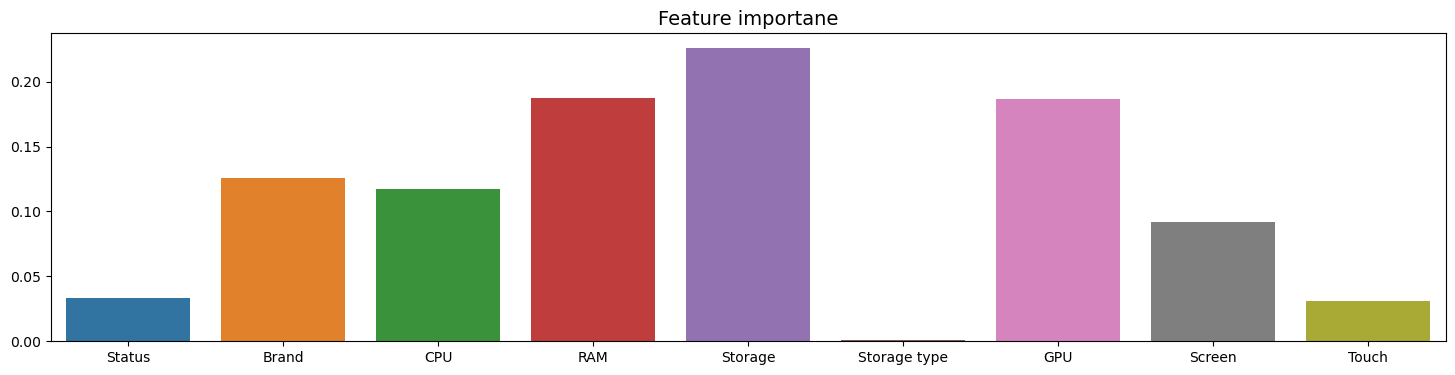

In [11]:
model = RandomForestRegressor(n_estimators=400,criterion='absolute_error')

# fit the model
model.fit(X_train, y_train)
# get importance

importance = model.feature_importances_

fig, ax = plt.subplots(1, 1, figsize=(18,4))
ax.set_title('Feature importance', fontsize=14)
sns.barplot(x=list(X.columns), y=importance,ax=ax)
pyplot.show()

As expected, most features have some importance except for Status. The exception is Storage type and Touch which affected the mean significantly but do no have that much importance in the model. This can be explained by the relative occurrences of each possible value

<Axes: title={'center': 'Touch vs Final Price'}, xlabel='Touch', ylabel='count'>

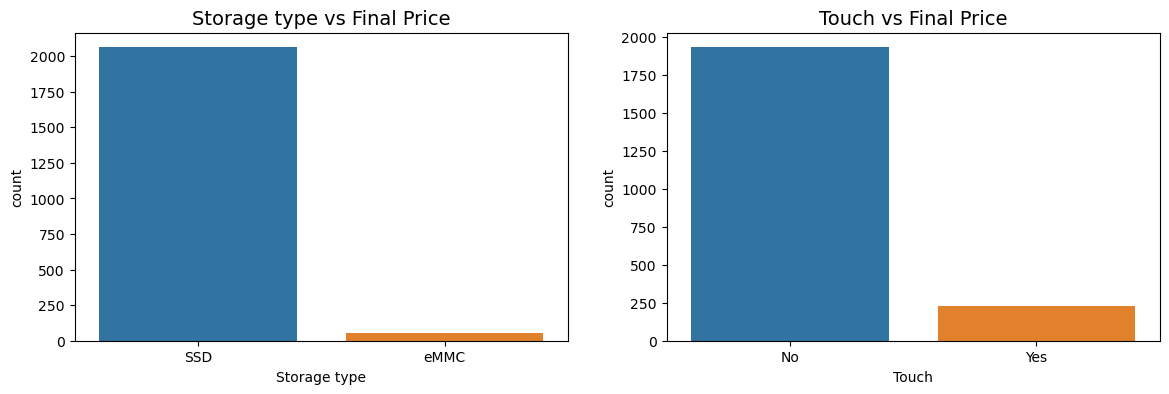

In [43]:
#for column in df.drop(['Final Price','Laptop','Model'],axis=1).columns:
    

my_order = df.groupby(by=['Storage type'])["Final Price"].count().iloc[::-1].sort_values().index
fig, ax = plt.subplots(1, 2, figsize=(14,4))
ax[0].set_title(f'Storage type vs Final Price', fontsize=14)
sns.countplot(df,x='Storage type', ax=ax[0])

my_order = df.groupby(by=['Touch'])["Final Price"].count().iloc[::-1].sort_values().index

ax[1].set_title(f'Touch vs Final Price', fontsize=14)
sns.countplot(df,x='Touch', ax=ax[1])

Since the likelihood of a certain answer occurring is so high, they are not a major factor towards how the model determines the final price